In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import os
import time
import random
import numpy as np
from skimage import transform
from IPython.display import display, clear_output
import tensorflow as tf

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from utils import FrameStack, Scheduler, calculate_expected_return
from a2c import GaussianA2C
from vec_env.subproc_vec_env import SubprocVecEnv

lr_scheduler = Scheduler(initial_value=1e-4, interval=10, decay_factor=0.95)

In [3]:
class Env():
    def __init__(self):
        self.env = gym.make("CarRacing-v0")
        self.action_space = self.env.action_space.shape[0]
        self.state_space  = (*self.env.observation_space.shape[0:2], 4)
        
    def reset(self):
        initial_frame = self.env.reset()
        def preprocess_frame(frame):
            frame = np.dot(frame[..., 0:3], [0.299, 0.587, 0.114])
            frame = frame / 255.0
            return frame
        self.frame_stack = FrameStack(initial_frame, preprocess_fn=preprocess_frame)
        self.done = False
        
    def step(self, action):
        if self.done:
            return 0
        frame, reward, done, info = self.env.step(action)
        self.frame_stack.add_frame(frame)
        self.done = done
        self.env.render()
        return reward
    
    def is_done(self):
        return self.done
    
    def get_state(self):
        return self.frame_stack.get_state()
        
def preprocess_frame(frame):
    frame = np.dot(frame[..., 0:3], [0.299, 0.587, 0.114])
    frame = frame / 255.0
    return frame

def make_env():
    return gym.make("CarRacing-v0")

num_envs = 8
envs = SubprocVecEnv([make_env for _ in range(num_envs)])

In [ ]:
discount_factor  = 0.99
save_interval    = 100
t_max            = 5
frame_stack_size = 4

-- Episode 2 --
Learning rate: 0.0001
Episode policy loss: -64.99564262060449
Episode value loss: 141.3993214443326
Episode entropy loss: 914.8210849761963
Episode loss: -3.4441928304731846
Average episode reward: -36.83904776283194



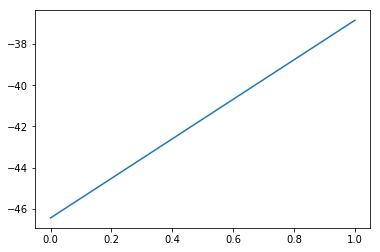

Resetting envronments...
Training...


In [ ]:
input_shape = (*envs.observation_space.shape[0:2], 4)
a2c_model = GaussianA2C(envs.action_space.shape[0], input_shape, tf.train.RMSPropOptimizer,
                        value_scale=0.5, entropy_scale=0.01, model_checkpoint=None, model_name="CarRacing-v0")

average_episode_rewards = []
episode = 0
while True:
    print("Resetting envronments...")
    episode += 1
    initial_frames = envs.reset()
    frame_stacks = [FrameStack(initial_frames[i], preprocess_fn=preprocess_frame) for i in range(num_envs)]
    dones = [False] * num_envs
    
    # While there are running environments
    print("Training...")
    learning_rate = lr_scheduler.get_value()
    total_reward = 0
    episode_loss = episode_policy_loss = episode_value_loss = episode_entropy_loss = 0
    average_episode_reward = []
    while sum(dones) < num_envs:
        states_mb, actions_mb, returns_mb, values_mb = [], [], [], []
        
        # Simulate game for some number of steps
        rewards_mb = []
        for _ in range(t_max):
            # Predict and value action given state
            # π(a_t | s_t; θ)
            states = [frame_stacks[i].get_state() if dones[i] == False else np.zeros(input_shape) for i in range(num_envs)]
            actions_mean, actions_variance, values = a2c_model.predict(states)

            # Sample action from a Gaussian distribution
            actions = np.random.normal(loc=actions_mean, scale=np.sqrt(actions_variance))
            envs.step_async(actions)
            frames, rewards, dones, infos = envs.step_wait()
            
            # Store state, action and reward
            states_mb.extend(states)
            actions_mb.extend(actions)
            rewards_mb.extend(rewards)
            values_mb.extend(np.squeeze(values, axis=-1))
            total_reward += np.sum(rewards)
            
            # Get new state
            for i in range(num_envs):
                frame_stacks[i].add_frame(frames[i])

        # Calculate return (discounted rewards over a trajectory)
        states = [frame_stacks[i].get_state() if dones[i] == False else np.zeros(input_shape) for i in range(num_envs)]
        last_values = a2c_model.predict(states)[-1]
        for i in range(num_envs):
            if dones[i] == False:
                returns_mb.extend(calculate_expected_return(rewards_mb[i::num_envs]+[last_values[i]], discount_factor)[:-1])
            else:
                returns_mb.extend(calculate_expected_return(rewards_mb[i::num_envs]+[0], discount_factor)[:-1])

        eploss, pgloss, vloss, entloss = a2c_model.train(states_mb, actions_mb, np.squeeze(returns_mb, axis=-1), values_mb, learning_rate=learning_rate)
        episode_loss         += eploss
        episode_policy_loss  += pgloss
        episode_value_loss   += vloss
        episode_entropy_loss += entloss
    average_episode_rewards.append(total_reward / num_envs)
    
    clear_output(wait=True)
    print("-- Episode {} --".format(episode))
    print("Learning rate:", learning_rate)
    print("Episode policy loss:", episode_policy_loss)
    print("Episode value loss:", episode_value_loss)
    print("Episode entropy loss:", episode_entropy_loss)
    print("Episode loss:", episode_loss)
    print("Average episode reward:", average_episode_rewards[-1])
    print("")
    plt.plot(np.arange(0, len(average_episode_rewards)), average_episode_rewards)
    plt.show()
    
    if episode % save_interval == 0:
        a2c_model.save()

print("Done!")

In [ ]:
print(np.array(rewards_mb[::num_envs]).shape)

In [ ]:
import time
env = DoomEnv(True)
greedy = True
for episode in range(10):
    env.reset()
    while not env.game.is_episode_finished():
        # Predict action given state: π(a_t | s_t; θ)
        action_prob = np.squeeze(a2c_model.predict(np.expand_dims(env.state, axis=0))[0])
        if greedy:
            action = np.argmax(action_prob)
        else:
            action = np.random.choice(np.arange(0, num_actions), p=action_prob) # Sample action stochastically
        action_one_hot = [False] * num_actions
        action_one_hot[action] = True

        # Take the action
        env.game.make_action(action_one_hot)
        time.sleep(0.016)
        
        if not env.game.is_episode_finished():
            # Get new state
            env.frame_stack.append(preprocess_frame(env.game.get_state().screen_buffer))
            env.state = np.stack(env.frame_stack, axis=2)